In [1]:
import numpy as np
import skimage.measure
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import random

In [2]:
# Define path to the files.
my_absolute_dirpath = os.path.abspath(os.path.dirname('CSCI561-FINALPROJECT-TEAM2'))

# Define datasets with which we will be working.
training_datasets = ["high_train_norm", "med_train_norm", "low_train_norm"]
validate_datasets = ["high_validate_norm", "med_validate_norm", "low_validate_norm"]

In [3]:
# Pool each image in a dataset of images. Also, compute a summary statistic for each image in the dataset.
def pooling_stats(dataset, pool_func, stat_func, p1, p2, col_width=192):
    """
    Parameters
    __________
    dataset = STRING name of dataset of images to run pooling on
    pool_func = function to run on pooling filter
    stat_func = function to take summary statistics across each pooled image
    p1 = first dimension of the pooling filter
    p2 = second dimension of the pooling filter

    Returns
    _______
    stats = list of stats (one stat per image)
    pool_list = list of pooled images
    pool_func
    stat_func
    (p1,p2) = tuple dimension of the pooling filter
    """
    # Read in data.

    selected_dataset = pd.read_csv(my_absolute_dirpath + "/normalized/" + dataset + ".csv")

    # We see that the images have been horizontally concatenated into a singe csv:
    # - 21120 columns (110 images x 192 longitude columns per image) + 1 column (first column) that has the lattitude values
    # - 288 rows
    # Let's divide the images up into their own dataframes and remove the lattitude and longitudes.
    if('Unnamed: 0' in selected_dataset.columns):
        selected_dataset.drop(['Unnamed: 0'],axis=1,inplace=True)

    selected_dataset.columns = range(len(selected_dataset.columns))
    i=0
    selected_dataset_list = []
    while i*col_width < len(selected_dataset.columns):
        i = i+1
        start = (i-1)*col_width
        stop = i*col_width
        selected_dataset_list.append(selected_dataset.iloc[:, start:stop])

    # Fix image orientation.
    original_images = selected_dataset_list.copy()
    for i in range(len(original_images)):
        original_images[i] = np.rot90(np.array(original_images[i]))

    # Pool the image using the give function and filter size.
    pool_list = selected_dataset_list.copy()
    for i in range(len(pool_list)):
        pool_list[i] = skimage.measure.block_reduce(np.rot90(pool_list[i]), (p1,p2), pool_func)[:-1,:-1]

    # Compute a summary statistic for the pixels of each image.
    stats = np.zeros((len(pool_list)))
    for i in range(len(stats)):
        stats[i] = stat_func(np.array(pool_list[i]).flatten())

    return {'dataset': dataset,'summary_stats_list': stats, 'pooled_image_list': pool_list, 'pooling_function': pool_func, 'summary_stats_func': stat_func, 'pooling_filter_dim': (p1,p2), 'original_images': original_images}

In [4]:
# Create a boxplot for each dataset given a pooling technique and summary statistic. This is intended the class separation provided by the feature we have created here.
def class_separation_boxplot(dataset_list, pool_func, stat_func, p1, p2):
    """
    REQUIRES
    ________
    dataset_list --> must be a list of 3 strings
    pool_func --> must be a numpy function
    stat_func --> must be a numpy function

    Parameters
    __________
    dataset_list = list of 3 STRING names of dataset of images to run pooling on
    pool_func = function to run on pooling filter
    stat_func = function to take summary statistics across each pooled image
    p1 = first dimension of the pooling filter
    p2 = second dimension of the pooling filter

    Returns
    _______
    fig = 8x8 figure with boxplots, original images, and pooled images
    """

    # Pool images and compute summary statistics across. 
    pooling_stats_list = []
    for d in dataset_list:
        pooling_stats_list.append(pooling_stats(dataset = d, pool_func = pool_func, stat_func = stat_func, p1 = p1, p2 = p2))

    # Store relevant info for making the boxplots and images.
    boxes = []
    column_names = []
    pool_func = ''
    stat_func = ''
    (p1,p2) = (0,0)
    pool_list = []
    lengths = []
    for i in range(len(pooling_stats_list)):
        boxes.append(pooling_stats_list[i]['summary_stats_list'])
        column_names.append(pooling_stats_list[i]['dataset'])
        pool_list.append(pooling_stats_list[i]['pooled_image_list'])
        pool_func = pooling_stats_list[i]['pooling_function']
        stat_func = pooling_stats_list[i]['summary_stats_func']
        (p1,p2) = pooling_stats_list[i]['pooling_filter_dim']
        lengths.append(len(pooling_stats_list[i]['original_images']))

    # Make the summary figure.
    fig = plt.figure(figsize=(20,20))
    fig.suptitle('Pooling Feature', fontsize=14, fontweight='bold')

    # Make adjacent boxplots for the three classes.
    ax1 = fig.add_subplot(421)
    ax1.boxplot(x=boxes, labels=column_names)
    ax1.set_title(str(stat_func).split(' ')[1] + 's for each ' + str(p1) + 'x' + str(p2) + ' ' + str(pool_func).split(' ')[1] + '-pooled images')
    ax1.set_xlabel('Dataset')
    ax1.set_ylabel(str(stat_func).split(' ')[1])

    # Make adjacent plots of the original and pooled images.
    img_index1 = random.randint(0, lengths[0]-1)
    ax2 = fig.add_subplot(423)
    ax2.imshow(pooling_stats_list[0]['original_images'][img_index1], cmap='bwr', interpolation='nearest')
    ax2.set_title(pooling_stats_list[0]['dataset'] + ' dataset: image #' + str(img_index1))
    ax2.set_ylabel('Lattitude')

    ax3 = fig.add_subplot(424)
    ax3.imshow(pooling_stats_list[0]['pooled_image_list'][img_index1], cmap='bwr', interpolation='nearest')
    ax3.set_title(pooling_stats_list[0]['dataset'] + ' dataset: image #' + str(img_index1) + ' pooled')

    img_index2 = random.randint(0, lengths[1]-1)
    ax4 = fig.add_subplot(425)
    ax4.imshow(pooling_stats_list[1]['original_images'][img_index2], cmap='bwr', interpolation='nearest')
    ax4.set_title(pooling_stats_list[1]['dataset'] + ' dataset: image #' + str(img_index2))
    ax4.set_ylabel('Lattitude')

    ax5 = fig.add_subplot(426)
    ax5.imshow(pooling_stats_list[1]['pooled_image_list'][img_index2], cmap='bwr', interpolation='nearest')
    ax5.set_title(pooling_stats_list[1]['dataset'] + ' dataset: image #' + str(img_index2) + ' pooled')

    img_index3 = random.randint(0, lengths[2]-1)
    ax6 = fig.add_subplot(427)
    ax6.imshow(pooling_stats_list[2]['original_images'][img_index3], cmap='bwr', interpolation='nearest')
    ax6.set_title(pooling_stats_list[2]['dataset'] + ' dataset: image #' + str(img_index3))
    ax6.set_xlabel('Longitude')
    ax6.set_ylabel('Lattitude')

    ax7 = fig.add_subplot(428)
    ax7.imshow(pooling_stats_list[2]['pooled_image_list'][img_index3], cmap='bwr', interpolation='nearest')
    ax7.set_title(pooling_stats_list[2]['dataset'] + ' dataset: image #' + str(img_index3) + ' pooled')
    ax7.set_xlabel('Longitude')

    return fig

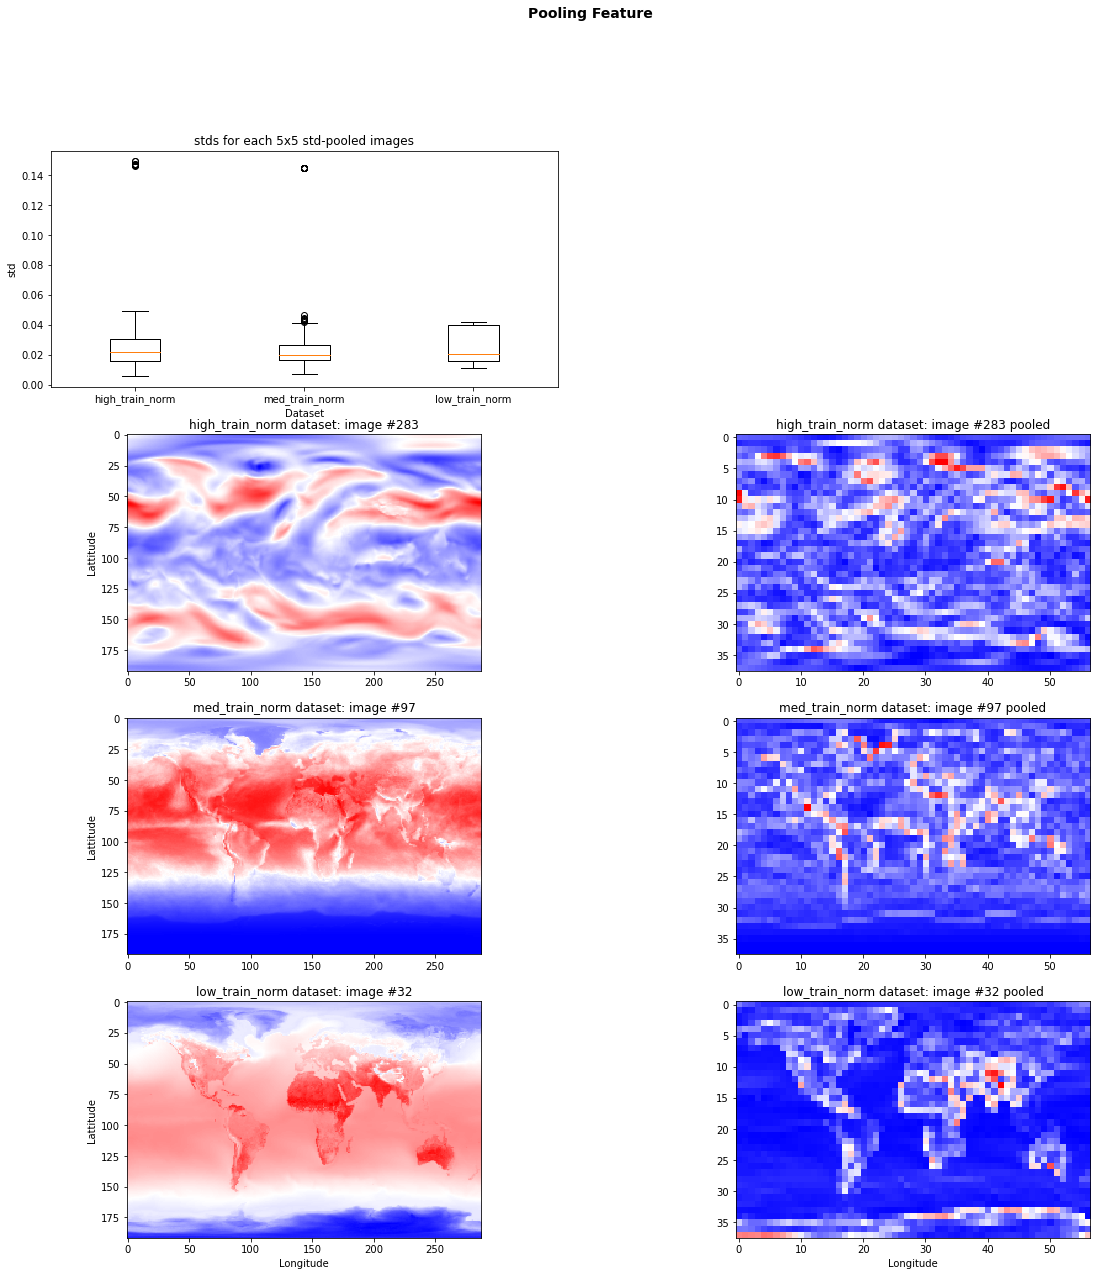

In [5]:
# Calling class_separation_boxplot will tke about 2 minutes to run.
fig1 = class_separation_boxplot(dataset_list = training_datasets, pool_func = np.std, stat_func = np.std, p1=5,p2=5)